# Spis treści
&emsp;[Informacje](#Informacje)
1. [Propozycja własna analizy tekstów](#1.-Propozycja-własna-analizy-tekstów)
2. [Przygotowanie korpusu](#2.-Przygotowanie-korpusu)
    1. [Wizualizacja danych](#Wizualizacja-danych)
3. [Przygotowanie chmury słów](#3.-Przygotowanie-chmury-słów)
    1. [Wizualizacja chmury słów](#Wizualizacja-chmury-słów)
4. [Sprawdzenie czy wśród dokumentów występują przyjęte kategorie/grupy odzwierciedlające przyjętą dychotomię](#4.-Sprawdzenie-czy-wśród-dokumentów-występują-przyjęte-kategorie/grupy-odzwierciedlające-przyjętą-dychotomię)
5. [Zbudowanie klasyfikatorów](#5.-Zbudowanie-klasyfikatorów)
6. [Wyznaczenie wskaźnika polaryzacji nastroju](#6.-Wyznaczenie-wskaźnika-polaryzacji-nastroju)

# Informacje

**Informacje o danych wykorzystanych do projektu:**

*   Źródło danych tekstowych to przekonwerotwane pliki o rozszerzeniu PDF ze strony: [sprawozdania stenograficzne z posiedzeń Sejmu](https://www.sejm.gov.pl/sejm9.nsf/stenogramy.xsp), a dokładniej Posiedzenie nr 75 z 9 maja 2023 oraz Posiedzenie nr 74 z 13 kwietnia 2023.
*   Pliki w formacie PDF zostały przekonwetowane przy użyciu [PDFtoTEXT](https://pdftotext.com/)
*   Słownik wykorzystany do analizy nastroju to VADER lexicon, który został przetłumaczony na język polski przy użyciu Google Translator.

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

**Uwagi odnośnie sposobu przygotowania danych:**<br>
* *Tekst poddawany analizie nie został przekonwertowany poprzez dostępne API, z powodu pomijania niektórych znaków specjalnych, które są pomocne w przypisywaniu tekstu odpowiednim politykom.*

* *Słownik został przetłumaczony w sposób ręczny z powodu limitu naniesionego na ilość przetłumaczonych tekstów z wykorzystaniem API.*

*Autor: BBrzek*

# 1. Propozycja własna analizy tekstów

Przedstawiona jest analiza tekstów zawierających wypowiedzi polityków z sejmu. Dane składają się z autora (polityka), jego wypowiedzi, przynależności do partii oraz informacji, czy jest on związany z obozem prawicowym czy lewicowym. Teksty są napisane w języku polskim, przy czym niektóre rozwiązania podczas analizy mogą posiadać pewne ograniczenia.

W analizie tekstu głównym celem było podzielenie go na lewicę i prawicę. Przeprowadzono podział na podstawie występowania słów jednocześnie w obu zbiorach, słów unikatowych dla lewicy oraz słów unikatowych dla prawicy. 

Następnie zastosowano metodę grupowania k-means, wizualizując partie polityków. Na wykresie partie reprezentowane są przez punkty, a grupy tworzone są na podstawie centroidów.

W kolejnym kroku przeprowadzono analizę tematów, wyodrębniając dwa główne wątki dotyczące nadmiaru zboża z Ukrainy na polskim rynku.

W dalszej części analizy utworzono trzy klasyfikatory, wykorzystujące metodę naive Bayes do przyporządkowania wypowiedzi polityków jako lewicowe lub prawicowe. Przedstawiono również macierz pomyłek dla wszystkich klasyfikatorów, wybierając ostatecznie najlepszy spośród nich. Pierwszy klasyfikator korzystał z wag binarnych, drugi z wag logarytmicznych, a trzeci z metody TF-IDF.

Ostatnim etapem analizy tekstu jest badanie nastroju poprzez wyznaczenie wskaźnika polaryzacji nastroju.

# 2. Przygotowanie korpusu

Przygotować korpus, który będzie wykorzystywany w dalszej analizie. W trakcie wstępnej analizy proszę oczyścić i znormalizować teksty, przeanalizować wyodrębnione termy i usunąć z analizy te, które według Państwa nie będą wnosiły istotnych informacji, decyzję uzasadnić, zredukować rzadkość macierzy wystąpień.

**Import bibliotek potrzebnych do oczyszczenia tekstu**

In [1]:
!pip install nltk
!pip install pyLDAvis
!pip install gensim
!pip install morfeusz2

Import bibliotek

In [2]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import drive
  
import requests
import re, os
import pandas as pd
import numpy as np

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from morfeusz2 import Morfeusz

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from gensim import corpora, models

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

C:\Users\Bartek\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Pobranie potrzebnych plików do analizy sentymentu oraz do tokenizera

In [3]:
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bartek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Bartek\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bartek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Podłączenie do usługi Google Drive oraz podanie ścieżek do plików:


*   75_ksiazka.txt i 74_b_ksiazka.txt - tekst do analizy
*   poslowie.txt - lista wszystkich osób zasiadających w sejmie
*   VADER_LEXICON_PL.txt - VADER LEXICON przetłumaczony na j. polski



In [4]:
if IN_COLAB:
    drive.mount("/content/gdrive/")
    pliki = ["/content/gdrive/My Drive/Colab Notebooks/data/75_ksiazka.txt", "/content/gdrive/My Drive/Colab Notebooks/data/74_b_ksiazka.txt"]
    politics = "/content/gdrive/My Drive/Colab Notebooks/data/poslowie.txt"
    lexicon_path = "/content/gdrive/My Drive/Colab Notebooks/data/VADER_LEXICON_PL.txt"
else:
    pliki = ["data/75_ksiazka.txt", "data/74_b_ksiazka.txt"]
    politics = "data/poslowie.txt"
    lexicon_path = "data/VADER_LEXICON_PL.txt"

Pobranie listy stopwords dla j. polskiego

In [5]:
response = requests.get('https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt')
stopwords = response.text.split('\n')

Przygotowanie słownika VADER_LEXICON_PL.txt

In [6]:
morfeusz = Morfeusz()

def lemmatize(text:str):
    return ' '.join([morfeusz.analyse(word.lower())[0][2][1].split(':')[0].lower() for word in text.split() if word not in stopwords])

In [7]:
def remove_stopwords(text:str, stopwords:list):
    words = nltk.word_tokenize(text, language='polish')
    filtered_words = [word.lower() for word in words if word.lower() not in stopwords]
    return filtered_words

In [8]:
df = pd.read_csv(lexicon_path, sep='\t', header=None, encoding='utf-8')
df[0] = df[0].str.replace(' się', '')
df[0] = df[0].apply(lambda x: str(x).lower())
df[0] = df[0].apply(lambda x: ' '.join(remove_stopwords(x, stopwords)))
df = df[df[0] != '']
df = df.drop_duplicates(subset=0)
VADER_PL = dict(zip(df[0], df[1]))

**Utworzenie funkcji do wstępnego oczyszczenia i znormalizowania tekstu bazowego**

In [9]:
# Funkcja zmieniająca nazwę autora w tekscie bazowym
def remove_author_error(data:list):
    data = [re.sub('Marlena Maląg:\n', 'Maląg Marlena Magdalena:\n', text) for text in data]
    return [re.sub('Marszałek:\n', 'Marszałek Elżbieta Witek:\n', text) for text in data]

# Funkcja zwracająca nazwę pliku wraz z rozszerzeniem
def extract_filename_with_extension(path):
    filename = os.path.basename(path)
    return filename

# Funkcja sprawdzająca czy linia rozpoczyna wypowiedź autora
def author_end_line(text:str):
    if ":\n" in text:
        text = re.sub(':\n', '', text)
    else:
        text = re.sub('\n', '', text)
    return text

# Funkcja tworząca listę wszystkich autorów w tekscie
def get_author(data:list):
    authors = []
    for i, text in enumerate(data):
        if len(text.split())>0:
            if ":\n" in text and len(text.split()) in range(2,5) and 'zmiany:\n' not in text and "," not in text and '.' not in text or text.split()[0] in ['Poseł'] and len(text.split()) in range(2,5) and "," not in text and '.' not in text and 'zmiany:\n' not in text:
              authors.append(author_end_line(text))
    return authors

# Funkcja zwracająca wypowiedź danego autora
def get_authors_text(authors, data):
    results = []
    actualResult = []
    authorResult = []
    check = False
    
    for text in data:
        if re.sub(':\n', '', text) in authors or re.sub('\n', '', text) in authors:
            if check:
                results.append(actualResult)
                actualResult = []
            authorResult.append(author_end_line(text))
            check = True
        elif check:
            actualResult.append(text)
    results.append(actualResult)
    return results, authorResult

# Funkcja usuwająca linie, które nie są treścią wypowiedzi a jedynie przerywnikami
def remove_elements(lst:list):
    i = 0
    while i < len(lst):
        if lst[i] == '\n':
            j = i + 1
            while j < len(lst) and j - i < 3 and j-i > 1:
                if lst[j] == '\n':
                    lst = lst[:i+1] + lst[j:]
                    j = i + 1
                j += 1
        i += 1
    return lst

# Funkcja zwracająca fragment listy aż do dwóch kolejnych znaków
def find_until_two_x(lst:list):
    i = 0
    while i < len(lst) - 1:
        if lst[i] == '\n' and lst[i+1] == '\n':
            return lst[:i+2]
        i += 1
    return lst

# Fukcja wstępnie czyszcząca wypowiedź z niepożądanych wyrażeń
def join_elements(data:list):
    result = ''.join(data)
    result = re.sub('[0-9]\n', '', result)
    result = re.sub('-\n', '', result)
    result = re.sub('\n', ' ', result)
    result = re.sub(r' +', ' ', result)
    result = re.sub(r'\(.*?\)', '', result)
    result = re.sub(r'\x0c[A-z0-9]+', '', result)
    result = re.sub(r"[^{ ĄĆĘŁŃÓŚŹŻąćęłńóśźż!?.,:-@}A-z0-9]", "", result)
    return result

# Funckja łącząca dwie wypowiedzi polityka następujące po sobie
def merge_authors_text(df):
    merged_df = pd.DataFrame(columns=['Source', 'Author', 'Text', 'Party'])
    prev_author = None
    merged_row = {'Source': None, 'Author': None, 'Text': '', 'Party': None}

    for index, row in df.iterrows():
        if prev_author is None or row['Author'] == prev_author or pd.isnull(row['Author']):
            merged_row['Text'] += ' ' + row['Text']
            if pd.notnull(row['Source']):
                merged_row['Source'] = row['Source']
            if pd.notnull(row['Party']):
                merged_row['Party'] = row['Party']
            if pd.notnull(row['Author']):
                merged_row['Author'] = row['Author']
        else:
            merged_df = pd.concat([merged_df, pd.DataFrame([merged_row])], ignore_index=True)
            merged_row = {'Source': row['Source'], 'Author': row['Author'], 'Text': row['Text'], 'Party': row['Party']}
        prev_author = row['Author']

    merged_df = pd.concat([merged_df, pd.DataFrame([merged_row])], ignore_index=True)
    return merged_df

# Funckja do usuwania niepożdanych zdań w tekście
def remove_sentence_from_text(text):
    x = re.sub(r'\s*Informacja.*?$', '', text)
    x = re.sub(r'\s*posiedzenie Sejmu w.*?$', '', x)
    x = re.sub(r'\s*\x0c.*?$', '', x)
    return x

Funkcje do oczyszczenia pliku poslowie.txt

In [10]:
# Funkcja zwracająca partie, imiona i nazwiska polityków zasiadających w sejmie
def get_political_party(politics:str):
    with open(politics, encoding='utf-8') as f:
        lines = f.readlines()
    firstNames = []
    lastNames = []
    parties = []

    data = [re.sub('\n','', item) for item in lines if 'koła' not in item.split() and 'klubu' not in item.split() and 'zaczynające' not in item.split() and item not in ['\n', '\n']]
    for i, text in enumerate(data):
        if i % 2 == 0:
            lastNames.append(text.split()[0])
            firstNames.append(' '.join(text.split()[1:]))
        else:
            parties.append(text)
    
    return parties, firstNames, lastNames

# Funckja przypisująca partię danemu politykowi
def connect_parties(author, firstNames, lastNames, parties):
    for i, name in enumerate(firstNames):
        if name in author and lastNames[i] in author:
            return parties[i]
    return False

Funckja przygotowująca tekst poprzez wykorzystanie poprzednich funkcji

In [11]:
def get_text_df(pliki:list, politics):
    df = pd.DataFrame(columns = ['Source','Author','Text'])
    for path in pliki:
        with open(path, encoding='utf-8') as f:
            lines = f.readlines()
        lines = remove_author_error(lines)
        authors = get_author(lines)
        authors.append('\x0cSPIS TREŚCI')
        data, authors = get_authors_text(authors, lines)
        results = []
        x = []
        for texts in data:
            result = remove_elements(texts)
            x = find_until_two_x(result)
            x = join_elements(x)
            results.append(x)

        parties, firstNames, lastNames = get_political_party(politics)
        party_of_politicians = []

        for author in authors:
            party_of_politicians.append(connect_parties(author, firstNames, lastNames, parties))
        
        new_df = pd.DataFrame(list(zip([extract_filename_with_extension(path)]*len(authors),party_of_politicians ,authors, results)), columns = ['Source','Party','Author','Text'])
        new_df = merge_authors_text(new_df)
        df = pd.concat([df, new_df], ignore_index=True)
        
        df = df[df['Author'] != '\x0cSPIS TREŚCI']
        df['Text'] = df['Text'].apply(remove_sentence_from_text)
        df = df[df['Text'] != '']
        df = df[df['Text'] != ' ']
        df = df[df['Party'] != False]

    return df

Informacje o wypowiedziach

In [166]:
dane_df = get_text_df(pliki, politics)
print("Liczba wszystkich słów:", dane_df['Text'].str.split().apply(len).sum())

Liczba wszystkich słów: 102240


**Dane zostały podzielone na:**


*   Lewicę - left_df (Lewica, KO, KP, LD, niez., Polska2050)
*   Prawicę - right_df (Konfederacja, PiS, Kukiz15, Wolnościowcy, Porozumienie)


Powodem przypisania posłów niezrzeszonych do lewicy jest to, że ich poglądy są lewicowe.


In [13]:
# Funckja zwracająca czy podana partia należy do prawicy czy do lewicy
def left_or_right(text:str):
    right = ['Konfederacja', 'PiS', 'Kukiz15', 'Wolnościowcy', 'Porozumienie']
    left = ['Lewica', 'KO', 'KP', 'LD', 'niez.', 'Polska2050' ]
    if text in right:
        return 'Prawica'
    elif text in left:
        return 'Lewica'
    else:
        return False

In [14]:
dane_df['Lemmatized'] = dane_df['Text'].apply(lemmatize)
dane_df['Division'] = dane_df['Party'].apply(left_or_right)

left_df = dane_df[dane_df['Division'] == 'Lewica']
right_df = dane_df[dane_df['Division'] == 'Prawica']

# Wizualizacja danych

Lewica

In [15]:
left_df.head(2)

,Source,Author,Text,Party,Lemmatized,Division
3,75_ksiazka.txt,Poseł Krzysztof Gawkowski,Pani Marszałek! Wysoka Izbo! Zgłaszam wniosek ...,Lewica,pani marszałek wysoki izba zgłaszać wniosek fo...,Lewica
5,75_ksiazka.txt,Poseł Joanna Mucha,"Dziękuję, pani marszałek. Szanowna Pani Marsza...",Polska2050,dziękować marszałek szanowny pani marszałek zg...,Lewica


Prawica

In [16]:
right_df.head(2)

,Source,Author,Text,Party,Lemmatized,Division
0,75_ksiazka.txt,Marszałek Elżbieta Witek,Otwieram posiedzenie. Na sekretarzy dzisiejs...,PiS,otwierać posiedzieć na sekretarz dzisiejszy ob...,Prawica
1,75_ksiazka.txt,Sekretarz Poseł Patryk Wicher,Szanowna Pani Marszałek! Wysoka Izbo! Informuj...,PiS,szanowny pani marszałek wysoki izba informować...,Prawica


# 3. Przygotowanie chmury słów

In [17]:
def prepare_bag(df):
    text = ' '.join(df['Lemmatized'])
    return text.split()

In [18]:
left_words = prepare_bag(left_df)
right_words = prepare_bag(right_df)
left_set = set(left_words)
right_set = set(right_words)

# Wizualizacja chmury słów

**3.1 Słów występujących w porównywanych dokumentach jednocześnie**

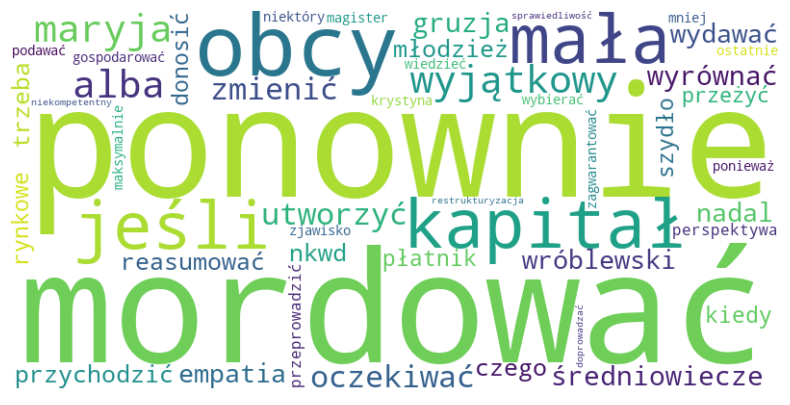

In [19]:
words_common_to_both_sets = left_set & right_set
wordcloud_common = WordCloud(stopwords = ['zdawać', "mielić", "ano","gotowić", "poprzeć"],background_color="white", width=800, height=400, max_words=50).generate(" ".join(words_common_to_both_sets))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_common, interpolation='bilinear')
plt.axis("off")
plt.show()

**3.2 Unikatowych słów występujących tylko w poszczególnych dokumentach**

Unikatowe dla lewicy

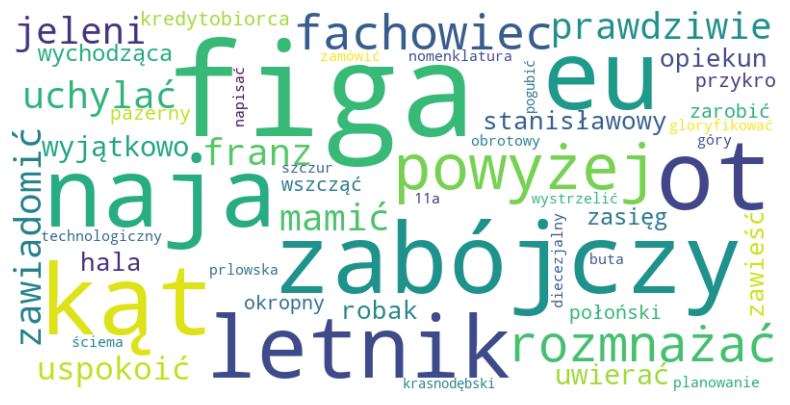

In [20]:
words_unique_to_left_set = left_set - right_set
wordcloud_left = WordCloud(background_color="white", width=800, height=400, max_words=50).generate(" ".join(words_unique_to_left_set))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_left, interpolation='bilinear')
plt.axis("off")
plt.show()

Unikatowe dla prawicy

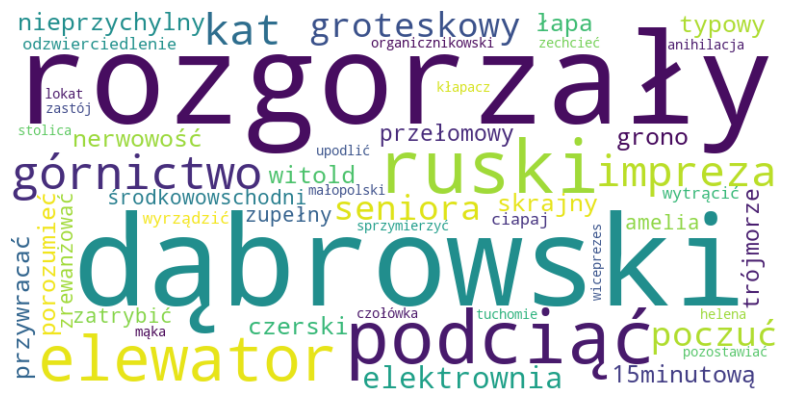

In [21]:
words_unique_to_right_set = right_set - left_set
wordcloud_right = WordCloud(background_color="white", width=800, height=400, max_words=50).generate(" ".join(words_unique_to_right_set))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_right, interpolation='bilinear')
plt.axis("off")
plt.show()

# 4. Sprawdzenie czy wśród dokumentów występują przyjęte kategorie/grupy odzwierciedlające przyjętą dychotomię

Reset numeracji rekordów

In [17]:
dane_df.reset_index(drop=True, inplace=True)

**4.1 Wykorzystując grupowanie – wyniki zinterpretować**

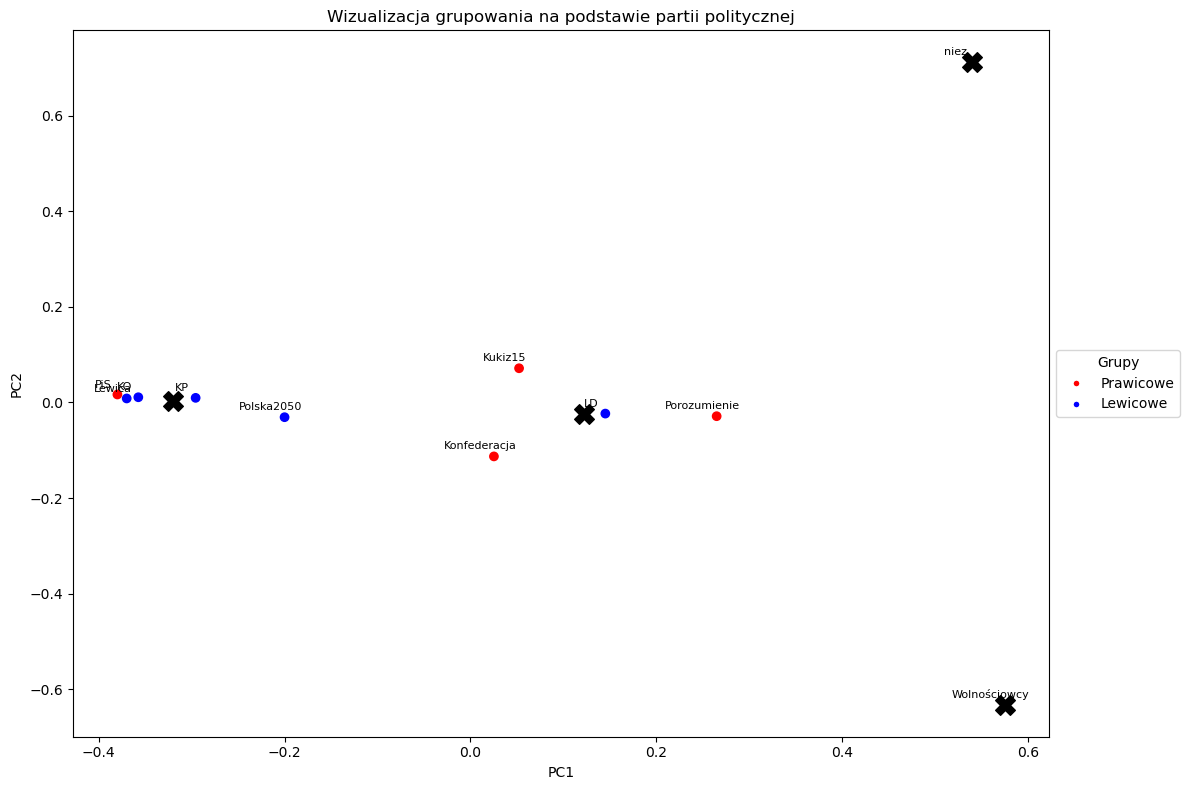

Partie leżące bliżej pierwszego centroidu:
Partia: KO
Partia: KP
Partia: Lewica
Partia: PiS
Partia: Polska2050

Partie leżące bliżej drugiego centroidu:
Partia: Konfederacja
Partia: Kukiz15
Partia: LD
Partia: Porozumienie

Partie leżące bliżej trzeciego centroidu:
Partia: niez.

Partie leżące bliżej czwartego centroidu:
Partia: Wolnościowcy


In [112]:
dane_g = dane_df[dane_df['Author'] != 'Marszałek Elżbieta Witek']
grouped_texts = dane_g.groupby('Party')['Text'].apply(lambda x: ' '.join(x)).reset_index()

stop_words = set(stopwords)

processed_texts = []
for text in grouped_texts['Text']:
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stop_words]
    processed_texts.append(tokens)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform([' '.join(tokens) for tokens in processed_texts])

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())


k = 4 
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(reduced_features)

group_labels = kmeans.labels_

grouped_texts['Party'] = pd.Categorical(grouped_texts['Party'])
grouped_texts['Party Code'] = grouped_texts['Party'].cat.codes

plt.figure(figsize=(12, 8))

colors = ['red' if party in ['Konfederacja', 'PiS', 'Kukiz15', 'Wolnościowcy', 'Porozumienie'] else 'blue' for party in grouped_texts['Party']]

scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors)

centroid_markers = plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=200, c='black')

for i, party in enumerate(grouped_texts['Party']):
    plt.annotate(party, (reduced_features[i, 0], reduced_features[i, 1]), textcoords="offset points", xytext=(-10, 5),
                 ha='center', fontsize=8, color='black')

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5)]
legend_labels = ['Prawicowe', 'Lewicowe']

plt.legend(legend_elements, legend_labels, title='Grupy', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Wizualizacja grupowania na podstawie partii politycznej')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
party_indices = []
for i, party in enumerate(grouped_texts['Party']):
    distances = kmeans.transform(reduced_features[i].reshape(1, -1))
    closest_index = distances.argmin()
    party_indices.append(closest_index)

plt.show()
print("Partie leżące bliżej pierwszego centroidu:")
for i, party_index in enumerate(party_indices):
    if party_index == 0:
        print(f"Partia: {grouped_texts['Party'][i]}")


print("\nPartie leżące bliżej drugiego centroidu:")
for i, party_index in enumerate(party_indices):
    if party_index == 1:
        print(f"Partia: {grouped_texts['Party'][i]}")
        

print("\nPartie leżące bliżej trzeciego centroidu:")
for i, party_index in enumerate(party_indices):
    if party_index == 2:
        print(f"Partia: {grouped_texts['Party'][i]}")
        
        
print("\nPartie leżące bliżej czwartego centroidu:")
for i, party_index in enumerate(party_indices):
    if party_index == 3:
        print(f"Partia: {grouped_texts['Party'][i]}")

Analiza wykresu wskazuje na pewne oddzielenie między partiami prawicowymi (Kukiz'15, Konfederacja, Porozumienie, Wolnościowcy) a partiami lewicowymi (Lewica, KO, KP, Polska 2050). Interesujący fakt to bliskość partii prawicowej PiS wobec partii lewicowych, co sugeruje pewne podobieństwo w niektórych aspektach politycznych między nimi.

Należy jednak zauważyć, że dwie partie lewicowe, Niezależni oraz Lewica Demokratyczna (LD) dodatkowo tworzą dwie osobne grupy. Pomimo tego gdyby zastosować grupowanie na dwie grupy to znajdowałyby się wraz z partiami prawicowymi w osobnej grupie. To może wskazywać na pewne podobieństwo w niektórych kwestiach lub współpracę między tymi partiami.



**4.2 Wykorzystując modele wątków (topic modelling) – wyniki zinterpretować.**

Utworzenie nowych grup ze wzgledu na przynależności partii do centroid

    1. ["KO", "KP", "Lewica", "PiS", "Polska2050"]
    2. ["Konfederacja", "Kukiz15", "LD", "Porozumienie"]
    3. ["niez."]
    4. ["Wolnościowcy"]

In [113]:
def assign_centroid(party):
    new_groups = {
    1: ["KO", "KP", "Lewica", "PiS", "Polska2050"],
    2: ["Konfederacja", "Kukiz15", "LD", "Porozumienie"],
    3: ["niez."],
    4: ["Wolnościowcy"]
    }
    
    for centroid, parties in new_groups.items():
        if party in parties:
            return centroid
    return "Error"

In [114]:
grouped_texts["Centroid"] = grouped_texts["Party"].apply(assign_centroid)


In [115]:
processed_texts = []
for text in grouped_texts['Text']:
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]
    lemmas = [morfeusz.analyse(token)[0][2][1].split(":")[0] for token in tokens]
    lemmas = [lem for lem in lemmas if lem not in stopwords + ["tenże","oczywiście","mówić", "mama", "polityka", "sytuacja", "sprawiedliwość", "obywatelski",  "komisja", "rolnictwo", "polityka", "czas", "powiedzieć", "zostać", "prawo", "rolny", "obywatelski", "komisja", "rolnictwo", "służba", "koalicja", "sprawa", "klub", "obywatelski", "prawo", "szkoła", "rok", "czas", "powiedzieć", "dzień", "polskie", "lato", "lewica", "służba", "fundusz", "komisja", "sprawiedliwość", "wszystek","pytać","polski", "poseł", "minister", "dziękować", "marszałek", "ustawa", "państwo", "projekt", "izba", "rolnik", "rząd", "wysoki", "oda", "sejm", "szanowny","móc", "wiedzieć", "mieć", "prosić", "chcieć"]]
    processed_texts.append(lemmas)
    
grouped_texts['Lemmatized'] = pd.Series(processed_texts)

dictionary = corpora.Dictionary(processed_texts)

corpus = [dictionary.doc2bow(tokens) for tokens in processed_texts]

num_topics = 2
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary)

num_words = 10

In [116]:
topics = {}
for topic_idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
    print(f"Temat {topic_idx + 1}:")
    words=[]
    for word, weight in topic:
        print(f"{word}: {weight}")
        words.append(word)
    
    topics[topic_idx] = words
    print()

Temat 1:
złoty: 0.0034614624455571175
europejski: 0.0034366955514997244
zboże: 0.002928113332018256
unia: 0.002785664750263095
zmiana: 0.0026183512527495623
dobry: 0.002528470242395997
Polska: 0.0025131849106401205
dotyczyć: 0.0024122821632772684
rolnica: 0.0024058870039880276
praca: 0.0024008648470044136

Temat 2:
europejski: 0.003755092853680253
chodzić: 0.0028296036180108786
złoty: 0.002693432616069913
stan: 0.002452014945447445
dotyczyć: 0.002445923862978816
ukraina: 0.0024063207674771547
zboże: 0.0024020809214562178
Polska: 0.0023209957871586084
cena: 0.0023185487370938063
zmiana: 0.0023097514640539885



Temat 1 skupia się głównie na kwestiach związanych z gospodarką i polityką, gdzie pojawiają się słowa takie jak "złoty", "europejski", "zboże" i "unia". Może to wskazywać na zainteresowanie tematami związanymi z rynkami finansowymi, handlem międzynarodowym i polityką europejską.

Temat 2 natomiast skupia się na zagadnieniach dotyczących sytuacji wewnętrznej kraju, gdzie pojawiają się słowa takie jak "chodzić", "stan", "Polska" i "cena". Może to wskazywać na zainteresowanie kwestiami związanymi z sytuacją społeczno-gospodarczą w kraju, działaniami wewnętrznymi oraz polityką krajową.

Porównując oba tematy, można zauważyć, że temat 1 skupia się na aspektach zewnętrznych i globalnych, takich jak polityka europejska i handel międzynarodowy, podczas gdy temat 2 bardziej skupia się na kwestiach wewnętrznych, związanych z sytuacją w kraju i działaniami na poziomie krajowym.

In [118]:
grouped_texts = grouped_texts.groupby('Centroid')['Lemmatized'].apply(lambda x: ' '.join([word for sublist in x for word in sublist])).reset_index()

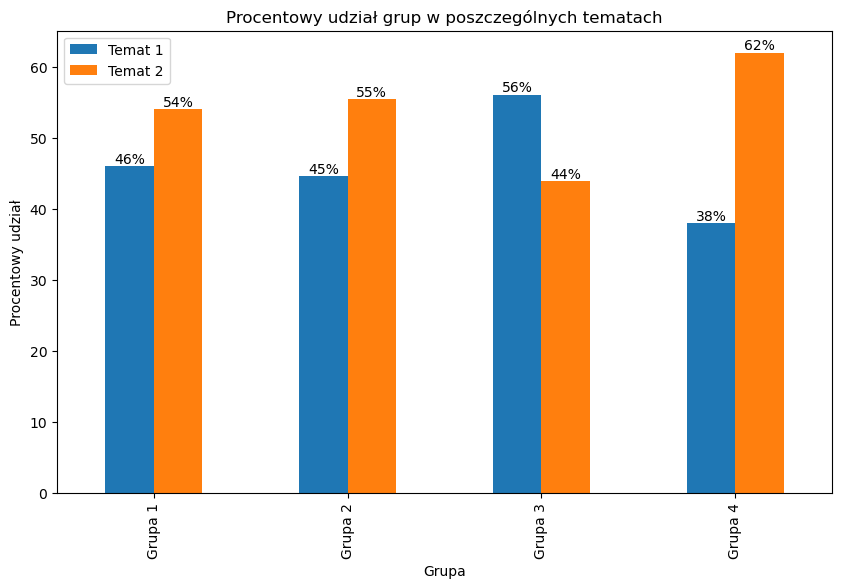

In [164]:
import pandas as pd

group_topic_contribution = {}

for group_idx, group in grouped_texts.groupby('Centroid'):
    group_text = ' '.join(group['Lemmatized'])
    group_contribution = {}
    
    for topic_idx, topic in enumerate(lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)):
        topic_words = [word for word, _ in topic[1]]
        topic_contribution = sum([group_text.count(word) for word in topic_words])
        group_contribution[f"Temat {topic_idx+1}"] = topic_contribution
    
    total_contribution = sum(group_contribution.values())
    group_topic_contribution[f"Grupa {group_idx}"] = group_contribution

group_topic_contribution_df = pd.DataFrame(group_topic_contribution).T
group_topic_contribution_df = group_topic_contribution_df.div(group_topic_contribution_df.sum(axis=1), axis=0) * 100


# Tworzenie wykresu słupkowego
fig, ax = plt.subplots(figsize=(10, 6))
group_topic_contribution_df.plot(kind='bar', ax=ax)

# Dodawanie etykiet osi x i y oraz tytułu
ax.set_xlabel('Grupa')
ax.set_ylabel('Procentowy udział')
ax.set_title('Procentowy udział grup w poszczególnych tematach')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}%', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
# Wyświetlanie wykresu
plt.show()


Grupa 1 ma 45.99% udziału w Temacie 1 i 54.01% udziału w Temacie 2.

Grupa 2 ma 44.56% udziału w Temacie 1 i 55.44% udziału w Temacie 2.

Grupa 3 ma 56.10% udziału w Temacie 1 i 43.90% udziału w Temacie 2.

Grupa 4 ma 38.00% udziału w Temacie 1 i 62.00% udziału w Temacie 2.

To oznacza, że Grupa 1 ma większy udział w Temacie 2 niż w Temacie 1, podobnie jak Grupa 2. Grupa 3 ma większy udział w Temacie 1 niż w Temacie 2, podczas gdy Grupa 4 ma większy udział w Temacie 2 niż w Temacie 1.

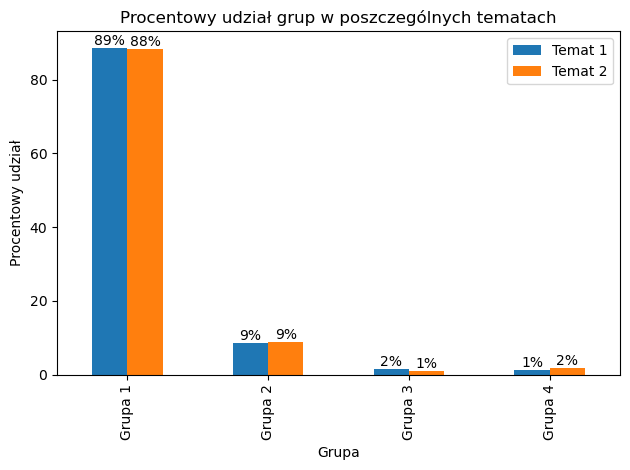

In [165]:
group_topic_contribution = {}

for group_idx, group in grouped_texts.groupby('Centroid'):
    group_text = ' '.join(group['Lemmatized'])
    group_contribution = {}
    
    for topic_idx, topic in enumerate(lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)):
        topic_words = [word for word, _ in topic[1]]
        topic_contribution = sum([group_text.count(word) for word in topic_words])
        group_contribution[f"Temat {topic_idx+1}"] = topic_contribution
    
    group_topic_contribution[f"Grupa {group_idx}"] = group_contribution

group_topic_contribution_df = pd.DataFrame(group_topic_contribution).T
group_topic_contribution_df = group_topic_contribution_df.div(group_topic_contribution_df.sum(axis=0), axis=1) * 100

fig, ax = plt.subplots()
group_topic_contribution_df.plot(kind='bar', ax=ax)
ax.set_xlabel('Grupa')
ax.set_ylabel('Procentowy udział')
ax.set_title('Procentowy udział grup w poszczególnych tematach')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}%', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Grupa 1 ma 88.64% udziału w Temacie 1 i 88.21% udziału w Temacie 2.

Grupa 2 ma 8.53% udziału w Temacie 1 i 8.99% udziału w Temacie 2.

Grupa 3 ma 1.55% udziału w Temacie 1 i 1.03% udziału w Temacie 2.

Grupa 4 ma 1.28% udziału w Temacie 1 i 1.77% udziału w Temacie 2.

To oznacza, że Grupa 1 dominuje w obu tematach, mając największy udział procentowy w obu przypadkach. Grupa 2 ma mniejszy udział, ale wciąż stanowi istotny odsetek w obu tematach. Grupa 3 i Grupa 4 mają niewielki udział procentowy, sugerując, że ich wpływ na tematy jest ograniczony.

# 5. Zbudowanie klasyfikatorów

**5.1 Z wagami binarnymi**

In [159]:
vectorizer = CountVectorizer(binary=True)
X_binary = vectorizer.fit_transform(dane_df['Lemmatized'])

y = dane_df['Division']

X_train, X_test, y_train, y_test = train_test_split(X_binary, y, test_size=0.2, random_state=6)

nb_classifier_binary = BernoulliNB(alpha=1.0, binarize=None, fit_prior=True, class_prior=None)
nb_classifier_binary.fit(X_train.toarray(), y_train)

example_text = "Wbrew temu, co robi ten rząd, Polska i tak staje się zielona, bo Polki i Polacy już wybrali. W słoneczne dni połowa energii pochodzi z fotowoltaiki. Pod warunkiem że jej nie wyłączacie. Bo dla was obywatele i obywatelki to konkurenci. Przez te 8 lat nie zrobiliście nic – nie zainwestowaliście w sieci, nie zbudowaliście magazynów energii, nawet nie wydaliście przeznaczonych na ten cel funduszy unijnych. Tylko odsunięcie od władzy tego rządu może sprawić, że będziemy poważnie traktować energię zieloną, odnawialną i zadbamy o swoje bezpieczeństwo energetyczne, bo o to w przyszłym rządzie zadbają Zieloni"
example_text_lemmatized = lemmatize(example_text)
example_vector = vectorizer.transform([example_text_lemmatized])
prediction = nb_classifier_binary.predict(example_vector)
print(f"Tekst poseł Klaudii Jachiry:\n{example_text}")
print("Przewidywana klasa:", prediction)

y_pred = nb_classifier_binary.predict(X_test)

confusion_mat_binary = confusion_matrix(y_test, y_pred)

accuracy = nb_classifier_binary.score(X_test.toarray(), y_test)
print("Dokładność (accuracy):", accuracy)


Tekst poseł Klaudii Jachiry:
Wbrew temu, co robi ten rząd, Polska i tak staje się zielona, bo Polki i Polacy już wybrali. W słoneczne dni połowa energii pochodzi z fotowoltaiki. Pod warunkiem że jej nie wyłączacie. Bo dla was obywatele i obywatelki to konkurenci. Przez te 8 lat nie zrobiliście nic – nie zainwestowaliście w sieci, nie zbudowaliście magazynów energii, nawet nie wydaliście przeznaczonych na ten cel funduszy unijnych. Tylko odsunięcie od władzy tego rządu może sprawić, że będziemy poważnie traktować energię zieloną, odnawialną i zadbamy o swoje bezpieczeństwo energetyczne, bo o to w przyszłym rządzie zadbają Zieloni
Przewidywana klasa: ['Lewica']
Dokładność (accuracy): 0.7106598984771574


**5.2. Z wagami logarytmicznymi**

In [160]:

vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(dane_df['Lemmatized'])
X_counts_transformed = np.log2(1 + X_counts.toarray())


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_counts_transformed)

y = dane_df['Division']


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=6)

nb_classifier_log = GaussianNB()
nb_classifier_log.fit(X_train, y_train)

example_text = "Wbrew temu, co robi ten rząd, Polska i tak staje się zielona, bo Polki i Polacy już wybrali. W słoneczne dni połowa energii pochodzi z fotowoltaiki. Pod warunkiem że jej nie wyłączacie. Bo dla was obywatele i obywatelki to konkurenci. Przez te 8 lat nie zrobiliście nic – nie zainwestowaliście w sieci, nie zbudowaliście magazynów energii, nawet nie wydaliście przeznaczonych na ten cel funduszy unijnych. Tylko odsunięcie od władzy tego rządu może sprawić, że będziemy poważnie traktować energię zieloną, odnawialną i zadbamy o swoje bezpieczeństwo energetyczne, bo o to w przyszłym rządzie zadbają Zieloni"
example_text_lemmatized = lemmatize(example_text)
example_vector = vectorizer.transform([example_text_lemmatized])
example_vector_transformed = np.log2(1 + example_vector.toarray())
example_vector_scaled = scaler.transform(example_vector_transformed)
prediction = nb_classifier_log.predict(example_vector_scaled)
print(f"Tekst poseł Klaudii Jachiry:\n{example_text}")
print("Przewidywana klasa:", prediction)

y_pred = nb_classifier_log.predict(X_test)

confusion_mat_log = confusion_matrix(y_test, y_pred)

accuracy = nb_classifier_log.score(X_test, y_test)
print("Dokładność (accuracy):", accuracy)


Tekst poseł Klaudii Jachiry:
Wbrew temu, co robi ten rząd, Polska i tak staje się zielona, bo Polki i Polacy już wybrali. W słoneczne dni połowa energii pochodzi z fotowoltaiki. Pod warunkiem że jej nie wyłączacie. Bo dla was obywatele i obywatelki to konkurenci. Przez te 8 lat nie zrobiliście nic – nie zainwestowaliście w sieci, nie zbudowaliście magazynów energii, nawet nie wydaliście przeznaczonych na ten cel funduszy unijnych. Tylko odsunięcie od władzy tego rządu może sprawić, że będziemy poważnie traktować energię zieloną, odnawialną i zadbamy o swoje bezpieczeństwo energetyczne, bo o to w przyszłym rządzie zadbają Zieloni
Przewidywana klasa: ['Lewica']
Dokładność (accuracy): 0.6700507614213198


**5.3 Z wagami TFIDF**

In [161]:

vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(dane_df['Lemmatized'])
total_term_counts = np.sum(X_count, axis=1)
tf = X_count / total_term_counts
num_documents = X_count.shape[0]
idf = np.log2(num_documents / np.sum(X_count > 0, axis=0))

tfidf = np.asarray(np.multiply(tf, idf))

scaler = MinMaxScaler()
tfidf_scaled = scaler.fit_transform(tfidf)

y = dane_df['Division']

X_train, X_test, y_train, y_test = train_test_split(tfidf_scaled, y, test_size=0.2, random_state=6)

nb_classifier_tfidf = GaussianNB()
nb_classifier_tfidf.fit(X_train, y_train)

example_text = "Wbrew temu, co robi ten rząd, Polska i tak staje się zielona, bo Polki i Polacy już wybrali. W słoneczne dni połowa energii pochodzi z fotowoltaiki. Pod warunkiem że jej nie wyłączacie. Bo dla was obywatele i obywatelki to konkurenci. Przez te 8 lat nie zrobiliście nic – nie zainwestowaliście w sieci, nie zbudowaliście magazynów energii, nawet nie wydaliście przeznaczonych na ten cel funduszy unijnych. Tylko odsunięcie od władzy tego rządu może sprawić, że będziemy poważnie traktować energię zieloną, odnawialną i zadbamy o swoje bezpieczeństwo energetyczne, bo o to w przyszłym rządzie zadbają Zieloni"
example_text_lemmatized = lemmatize(example_text)
example_vector = vectorizer.transform([example_text_lemmatized])
example_vector_transformed = vectorizer.transform([example_text_lemmatized])
example_vector_tfidf = np.multiply(example_vector_transformed.toarray(), idf)
example_vector_scaled = scaler.transform(np.asarray(example_vector_tfidf))
prediction = nb_classifier_tfidf.predict(example_vector_scaled)
print(f"Tekst poseł Klaudii Jachiry:\n{example_text}")
print("Przewidywana klasa:", prediction)

y_pred = nb_classifier_tfidf.predict(X_test)

confusion_mat_tfidf = confusion_matrix(y_test, y_pred)

accuracy = nb_classifier_tfidf.score(X_test, y_test)
print("Dokładność (accuracy):", accuracy)


Tekst poseł Klaudii Jachiry:
Wbrew temu, co robi ten rząd, Polska i tak staje się zielona, bo Polki i Polacy już wybrali. W słoneczne dni połowa energii pochodzi z fotowoltaiki. Pod warunkiem że jej nie wyłączacie. Bo dla was obywatele i obywatelki to konkurenci. Przez te 8 lat nie zrobiliście nic – nie zainwestowaliście w sieci, nie zbudowaliście magazynów energii, nawet nie wydaliście przeznaczonych na ten cel funduszy unijnych. Tylko odsunięcie od władzy tego rządu może sprawić, że będziemy poważnie traktować energię zieloną, odnawialną i zadbamy o swoje bezpieczeństwo energetyczne, bo o to w przyszłym rządzie zadbają Zieloni
Przewidywana klasa: ['Lewica']
Dokładność (accuracy): 0.6649746192893401


**Spośród tych trzech klasyfikatorów proszę wybrać najlepszy (w oparciu o miary wyliczone z macierzy pomyłek) i go zinterpretować.**

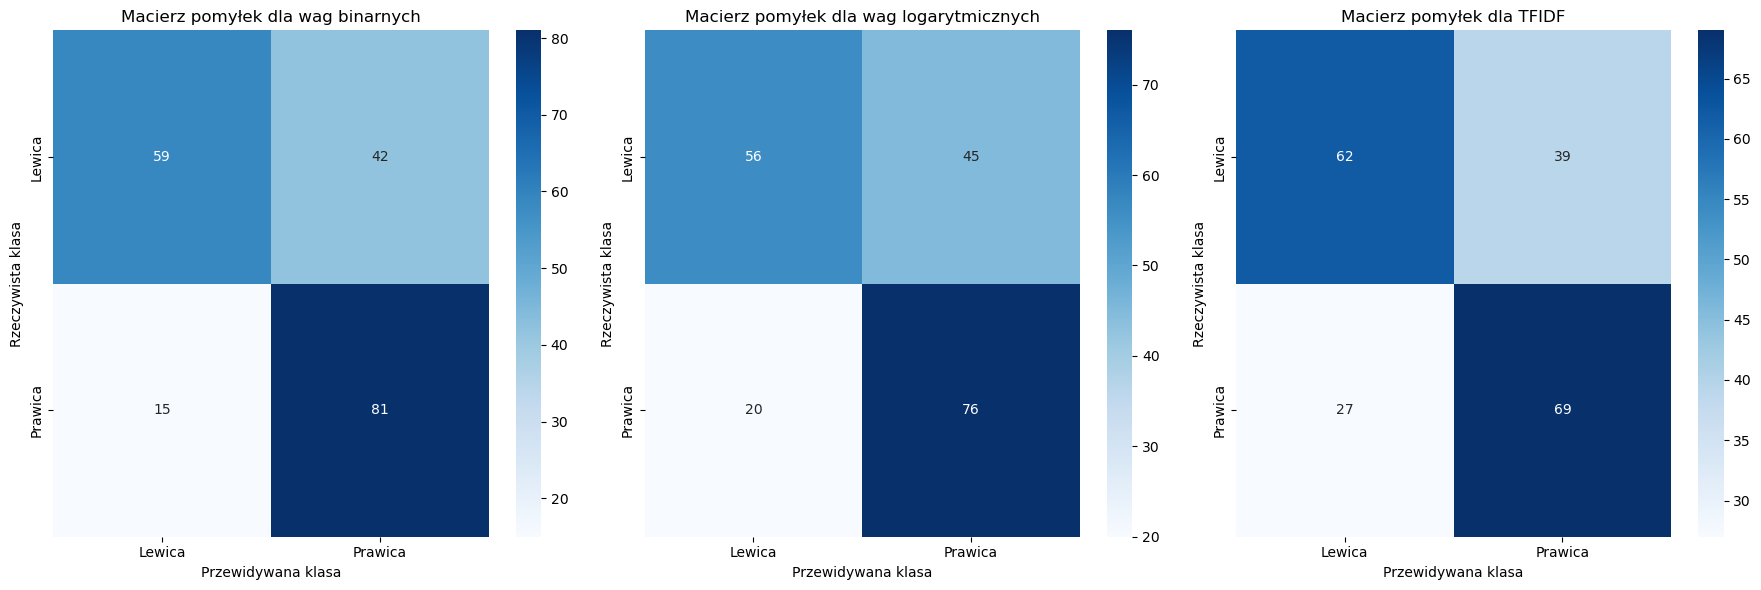

In [30]:
unique_labels = np.unique(y_test)
class_names = [unique_labels[0], unique_labels[1]]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(confusion_mat_binary, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Przewidywana klasa')
axes[0].set_ylabel('Rzeczywista klasa')
axes[0].set_title('Macierz pomyłek dla wag binarnych')
axes[0].set_xticks([0.5, 1.5])
axes[0].set_yticks([0.5, 1.5])
axes[0].set_xticklabels(class_names)
axes[0].set_yticklabels(class_names)

sns.heatmap(confusion_mat_log, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_xlabel('Przewidywana klasa')
axes[1].set_ylabel('Rzeczywista klasa')
axes[1].set_title('Macierz pomyłek dla wag logarytmicznych')
axes[1].set_xticks([0.5, 1.5])
axes[1].set_yticks([0.5, 1.5])
axes[1].set_xticklabels(class_names)
axes[1].set_yticklabels(class_names)

sns.heatmap(confusion_mat_tfidf, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_xlabel('Przewidywana klasa')
axes[2].set_ylabel('Rzeczywista klasa')
axes[2].set_title('Macierz pomyłek dla TFIDF')
axes[2].set_xticks([0.5, 1.5])
axes[2].set_yticks([0.5, 1.5])
axes[2].set_xticklabels(class_names)
axes[2].set_yticklabels(class_names)

plt.tight_layout()
plt.show()


Interpretacja klasyfikatora wykorzystujacego wagi binarne:

* W klasie 0, która została zinterpretowana jako "Lewica", mieliśmy 59 poprawnych predykcji. Oznacza to, że 59 przykładów należących do klasy "Lewica" zostało poprawnie sklasyfikowanych jako "Lewica".
* W klasie 0, mieliśmy 42 błędne predykcje. Oznacza to, że 42 przykłady, które rzeczywiście należały do klasy "Lewica", zostały błędnie sklasyfikowane jako "Prawica".
* W klasie 1, która została zinterpretowana jako "Prawica", mieliśmy 81 poprawnych predykcji. Oznacza to, że 81 przykładów należących do klasy "Prawica" zostało poprawnie sklasyfikowanych jako "Prawica".
* W klasie 1, mieliśmy 15 błędnych predykcji. Oznacza to, że 15 przykładów, które rzeczywiście należały do klasy "Prawica", zostały błędnie sklasyfikowane jako "Lewica".

Podsumowując, model dokonał łącznie 59 poprawnych predykcji dla klasy "Lewica" i 81 poprawnych predykcji dla klasy "Prawica". Jednocześnie, dokonał 42 błędnych predykcji, przypisując przykłady klasy "Lewica" do klasy "Prawica", oraz 15 błędnych predykcji, przypisując przykłady klasy "Prawica" do klasy "Lewica".

In [31]:
def recall_specify(confusion_mat):
    recall_class_0 = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])
    recall_class_1 = confusion_mat[1, 1] / (confusion_mat[1, 0] + confusion_mat[1, 1])
    
    specificity_class_0 = confusion_mat[1, 1] / (confusion_mat[1, 0] + confusion_mat[1, 1])
    specificity_class_1 = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])

    print("Czułość (Recall) dla klasy 0:", recall_class_0)
    print("Czułość (Recall) dla klasy 1:", recall_class_1)
    print("Swoistość (Specificity) dla klasy 0:", specificity_class_0)
    print("Swoistość (Specificity) dla klasy 1:", specificity_class_1)



In [32]:
print("Binarny")
recall_specify(confusion_mat_binary)
print("\nLogarytmiczny")
recall_specify(confusion_mat_log)
print("\nTFIDF")
recall_specify(confusion_mat_tfidf)

Binarny
Czułość (Recall) dla klasy 0: 0.5841584158415841
Czułość (Recall) dla klasy 1: 0.84375
Swoistość (Specificity) dla klasy 0: 0.84375
Swoistość (Specificity) dla klasy 1: 0.5841584158415841

Logarytmiczny
Czułość (Recall) dla klasy 0: 0.5544554455445545
Czułość (Recall) dla klasy 1: 0.7916666666666666
Swoistość (Specificity) dla klasy 0: 0.7916666666666666
Swoistość (Specificity) dla klasy 1: 0.5544554455445545

TFIDF
Czułość (Recall) dla klasy 0: 0.6138613861386139
Czułość (Recall) dla klasy 1: 0.71875
Swoistość (Specificity) dla klasy 0: 0.71875
Swoistość (Specificity) dla klasy 1: 0.6138613861386139


Najlepszą metodą, na podstawie analizy czułości (recall) i swoistości (specificity), jest metoda binarna z wykorzystaniem wag binarnych. Dla klasy 0 osiągnęła ona czułość (recall) wynoszącą 0.584, co oznacza, że poprawnie zidentyfikowała 58.4% przypadków należących do tej klasy. Ponadto, metoda binarna osiągnęła swoistość (specificity) dla klasy 0 równą 0.84375, co oznacza, że poprawnie sklasyfikowała 84.4% przypadków nie należących do klasy 0.

Dla klasy 1, metoda binarna osiągnęła jeszcze lepsze wyniki. Czułość (recall) dla klasy 1 wynosi 0.84375, co oznacza, że poprawnie zidentyfikowała 84.4% przypadków tej klasy. Swoistość (specificity) dla klasy 1 również była wysoka i wyniosła 0.5841584158415841, co oznacza, że poprawnie sklasyfikowała 58.4% przypadków nie należących do klasy 1.

W przypadku tej najlepszej metody binarnej z wagami binarnymi, osiągnięto wysoką skuteczność zarówno w rozpoznawaniu przypadków klasy 0, jak i klasy 1.

# 6. Wyznaczenie wskaźnika polaryzacji nastroju

In [135]:
sia = SentimentIntensityAnalyzer()
sia.lexicon.update(VADER_PL)
dane_df['Sentiment'] = dane_df['Lemmatized'].apply(lambda x: sia.polarity_scores(x))
dane_without_neu = dane_df.drop(dane_df[dane_df['Sentiment'].apply(lambda x: x.get('neu', 0) > 0.6)].index)

In [136]:
def assign_labels(sentyment):
    if sentyment['compound'] < 0:
        return 'negatywny'
    elif sentyment['compound'] == 0:
        return 'neutralny'
    else:
        return 'pozytywny'

In [137]:
dane_df['Label'] = dane_df['Sentiment'].apply(assign_labels)

In [138]:
left_df = dane_without_neu[dane_without_neu['Division']=='Lewica']
right_df = dane_without_neu[dane_without_neu['Division']=='Prawica']

left_result = sia.polarity_scores(' '.join(left_df['Text']))
right_result = sia.polarity_scores(' '.join(right_df['Text']))

In [139]:
left_result = [left_result['compound'],
    left_result['neg'],
    left_result['neu'],
    left_result['pos']]
right_result = [right_result['compound'],
    right_result['neg'],
    right_result['neu'],
    right_result['pos']]

Wynik dla lewicy:	[0.9989, 0.081, 0.724, 0.195]
Wynik dla prawicy:	[0.9993, 0.043, 0.686, 0.271]


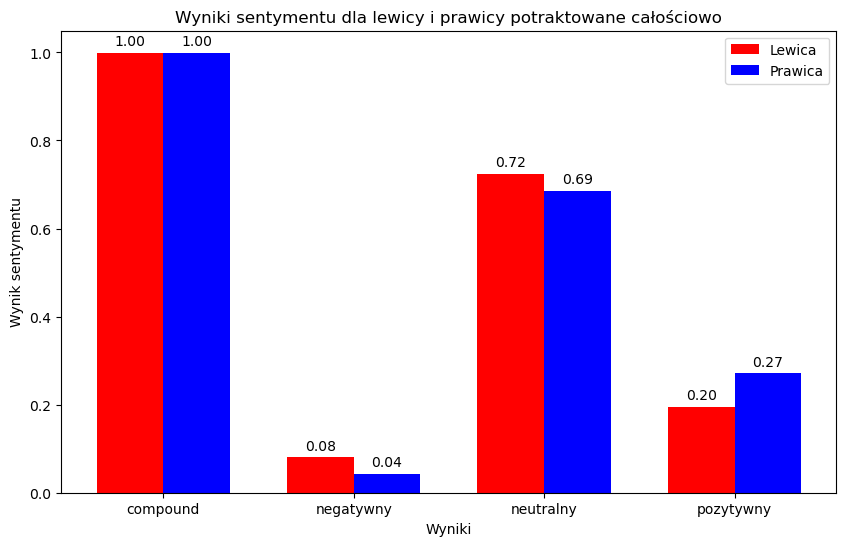

In [152]:
labels = ['compound', 'negatywny', 'neutralny', 'pozytywny']
width = 0.35
ind = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(ind, left_result, width, color='r', label='Lewica')
rects2 = ax.bar(ind + width, right_result, width, color='b', label='Prawica')
ax.set_xlabel('Wyniki')
ax.set_ylabel('Wynik sentymentu')
ax.set_title('Wyniki sentymentu dla lewicy i prawicy potraktowane całościowo')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)
ax.legend()
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

plt.show()
print(f"Wynik dla lewicy:\t{left_result}\nWynik dla prawicy:\t{right_result}")

Dla grupy lewicy:

* Wartość "compound" wynosi 0.9989. Wartość ta reprezentuje ogólny nastroj tekstu, gdzie wartości bliżej 1 oznaczają bardziej pozytywny nastroj, a wartości bliżej -1 oznaczają bardziej negatywny nastroj. W przypadku wartości 0.9989 możemy stwierdzić, że teksty lewicy mają silnie pozytywny nastroj.
* Wartość "neg" wynosi 0.081, co wskazuje na obecność pewnego stopnia negatywności w tekstach lewicy.
* Wartość "neu" wynosi 0.724, co oznacza, że większość tekstów lewicy jest sklasyfikowana jako neutralne.
* Wartość "pos" wynosi 0.195, co wskazuje na obecność pewnego stopnia pozytywności w tekstach lewicy.


Dla grupy prawicy:

* Wartość "compound" wynosi 0.9993, co wskazuje na bardzo silnie pozytywny nastroj tekstów prawicy.
* Wartość "neg" wynosi 0.043, co sugeruje minimalną obecność negatywności w tekstach prawicy.
* Wartość "neu" wynosi 0.686, co oznacza, że większość tekstów prawicy jest sklasyfikowana jako neutralne.
* Wartość "pos" wynosi 0.271, co wskazuje na obecność pewnego stopnia pozytywności w tekstach prawicy.



W ogólności wyniki te wskazują na to, że zarówno teksty lewicy, jak i prawicy mają tendencję do wyrażania pozytywnego nastroju. Oba wyniki mają podobne wartości neutralności, przy czym teksty lewicy wykazują nieco większą negatywność niż teksty prawicy, a teksty prawicy wykazują nieco większą pozytywność niż teksty lewicy.



In [155]:
left_df = dane_df[dane_df['Division']=='Lewica']
right_df = dane_df[dane_df['Division']=='Prawica']

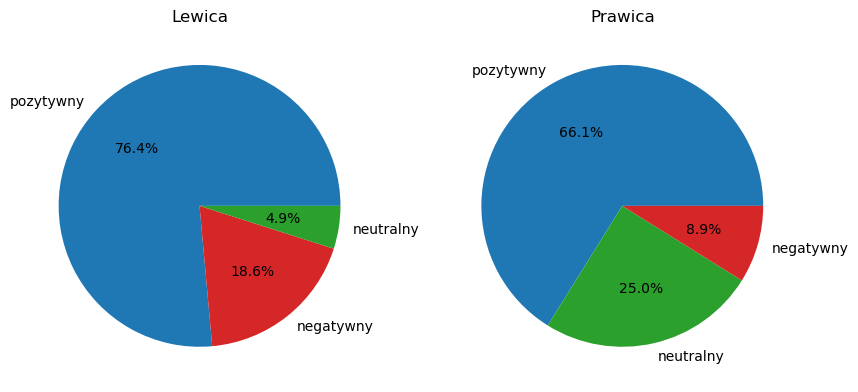

In [151]:
left_data = left_df['Label'].value_counts().tolist()
left_labels = left_df['Label'].value_counts().index.tolist()

right_data = right_df['Label'].value_counts().tolist()
right_labels = right_df['Label'].value_counts().index.tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.pie(left_data, labels=left_labels, autopct='%1.1f%%', colors=['#1f77b4','#d62728', '#2ca02c'])
ax1.set_title('Lewica')
ax2.pie(right_data, labels=right_labels, autopct='%1.1f%%', colors=['#1f77b4', '#2ca02c', '#d62728'])
ax2.set_title('Prawica')

plt.show()

Dla Lewicy:

* 18.6% wypowiedzi zostało zaklasyfikowanych jako negatywne,
* 76.4% wypowiedzi zostało zaklasyfikowanych jako pozytywne,
* 4.9% wypowiedzi zostało zaklasyfikowanych jako neutralne.

Większość wypowiedzi (76.4%) zostało zaklasyfikowanych jako pozytywne, co wskazuje na tendencję do wyrażania pozytywnego nastroju w tekstach lewicy.
Relatywnie niewielki odsetek wypowiedzi (4.9%) został zaklasyfikowany jako neutralny, co sugeruje, że teksty lewicy mają skłonność do wyrażania silnych nastrojów.


<br>
Dla Prawicy:

* 8.9% wypowiedzi zostało zaklasyfikowanych jako negatywne,
* 66.1% wypowiedzi zostało zaklasyfikowanych jako pozytywne,
* 25% wypowiedzi zostało zaklasyfikowanych jako neutralne.

Podobnie jak w przypadku lewicy, większość wypowiedzi (66.1%) zostało zaklasyfikowanych jako pozytywne.
W przeciwieństwie do lewicy, większy odsetek wypowiedzi (25%) został zaklasyfikowany jako neutralny, co wskazuje na tendencję do bardziej zrównoważonego wyrażania nastrojów.

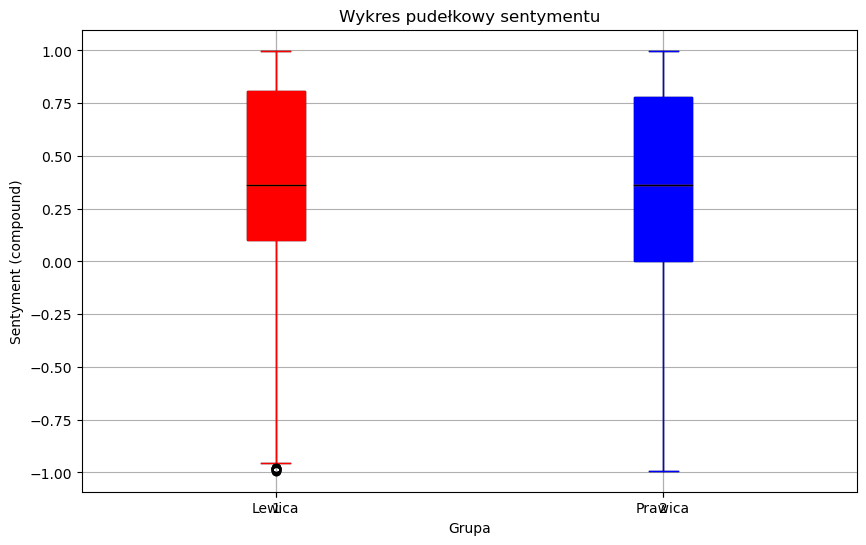

Informacje dla grupy Lewica:
--------------------------
Mediana: 0.3612
Q1 (25%): 0.1027
Q3 (75%): 0.8074
Minimalna wartość: -0.9908
Maksymalna wartość: 0.9967
IQR (rozstęp międzykwartylowy): 0.7047

Informacje dla grupy Prawica:
---------------------------
Mediana: 0.3612
Q1 (25%): 0.0000
Q3 (75%): 0.7783
Minimalna wartość: -0.9917
Maksymalna wartość: 0.9989
IQR (rozstęp międzykwartylowy): 0.7783


In [154]:
plt.figure(figsize=(10, 6))

# Wygenerowanie wykresu pudełkowego dla sentymentu (compound) dla lewicy i prawicy
plt.boxplot([left_df['Sentiment'].apply(lambda x: x['compound']),
             right_df['Sentiment'].apply(lambda x: x['compound'])],
            labels=['Lewica', 'Prawica'],
            patch_artist=True)

# Modyfikowanie elementów skrzynki dla grupy 'Lewica'
boxplot1 = plt.boxplot(left_df['Sentiment'].apply(lambda x: x['compound']), positions=[1], patch_artist=True)
for element in ['boxes', 'whiskers', 'medians', 'caps']:
    plt.setp(boxplot1[element], color='red')  # Ustawienie koloru niebieskiego dla elementów skrzynki 'Lewica'
plt.setp(boxplot1['medians'], color='black')

# Modyfikowanie elementów skrzynki dla grupy 'Prawica'
boxplot2 = plt.boxplot(right_df['Sentiment'].apply(lambda x: x['compound']), positions=[2], patch_artist=True)
for element in ['boxes', 'whiskers', 'medians', 'caps']:
    plt.setp(boxplot2[element], color='blue')  # Ustawienie koloru czerwonego dla elementów skrzynki 'Prawica'
plt.setp(boxplot2['medians'], color='black')

plt.xlabel('Grupa')
plt.ylabel('Sentyment (compound)')
plt.title('Wykres pudełkowy sentymentu')
plt.grid(True)
left_sentiment = left_df['Sentiment'].apply(lambda x: x['compound'])
right_sentiment = right_df['Sentiment'].apply(lambda x: x['compound'])
plt.show()
print("Informacje dla grupy Lewica:")
print("--------------------------")
print("Mediana: {:.4f}".format(np.median(left_sentiment)))
print("Q1 (25%): {:.4f}".format(np.percentile(left_sentiment, 25)))
print("Q3 (75%): {:.4f}".format(np.percentile(left_sentiment, 75)))
print("Minimalna wartość: {:.4f}".format(np.min(left_sentiment)))
print("Maksymalna wartość: {:.4f}".format(np.max(left_sentiment)))
print("IQR (rozstęp międzykwartylowy): {:.4f}".format(np.percentile(left_sentiment, 75) - np.percentile(left_sentiment, 25)))
print("")

print("Informacje dla grupy Prawica:")
print("---------------------------")
print("Mediana: {:.4f}".format(np.median(right_sentiment)))
print("Q1 (25%): {:.4f}".format(np.percentile(right_sentiment, 25)))
print("Q3 (75%): {:.4f}".format(np.percentile(right_sentiment, 75)))
print("Minimalna wartość: {:.4f}".format(np.min(right_sentiment)))
print("Maksymalna wartość: {:.4f}".format(np.max(right_sentiment)))
print("IQR (rozstęp międzykwartylowy): {:.4f}".format(np.percentile(right_sentiment, 75) - np.percentile(right_sentiment, 25)))

* Mediana sentymentu wynosi 0.3612, podobnie jak w grupie Prawica.
* Wartość pierwszego kwartyla (Q1) dla grupy Lewica wynosi 0.1027, co oznacza, że 25% wypowiedzi ma sentyment mniejszy niż ta wartość. W grupie Prawica Q1 wynosi 0.0, czyli 25% wypowiedzi ma sentyment równy lub większy od zera.
* Wartość trzeciego kwartyla (Q3) dla grupy Lewica wynosi 0.8074, co oznacza, że 75% wypowiedzi ma sentyment mniejszy niż ta wartość. W grupie Prawica Q3 wynosi 0.7783, czyli 75% wypowiedzi ma sentyment mniejszy niż ta wartość.
* Minimalna wartość sentymentu dla grupy Lewica wynosi -0.9908, a dla grupy Prawica wynosi -0.9917. Są to najmniejsze wartości sentymentu w obu grupach.
* Maksymalna wartość sentymentu dla grupy Lewica wynosi 0.9967, a dla grupy Prawica wynosi 0.9989. Są to największe wartości sentymentu w obu grupach.
* Różnica między trzecim a pierwszym kwartylem (IQR) dla grupy Lewica wynosi 0.7047, a dla grupy Prawica wynosi 0.7783. Oznacza to, że rozproszenie wartości sentymentu w grupie Prawica jest nieco większe niż w grupie Lewica.


Podsumowując, wartości sentymentu dla grupy Lewica i grupy Prawica są do siebie podobne, ale istnieją pewne różnice w wartościach kwartylowych, wartościach minimalnych i maksymalnych oraz rozproszeniu (IQR). Grupa Prawica ma nieco wyższe wartości w Q1, Q3 i maksymalne wartości sentymentu, co sugeruje, że sentyment w tej grupie może być bardziej skoncentrowany w kierunku pozytywnego.

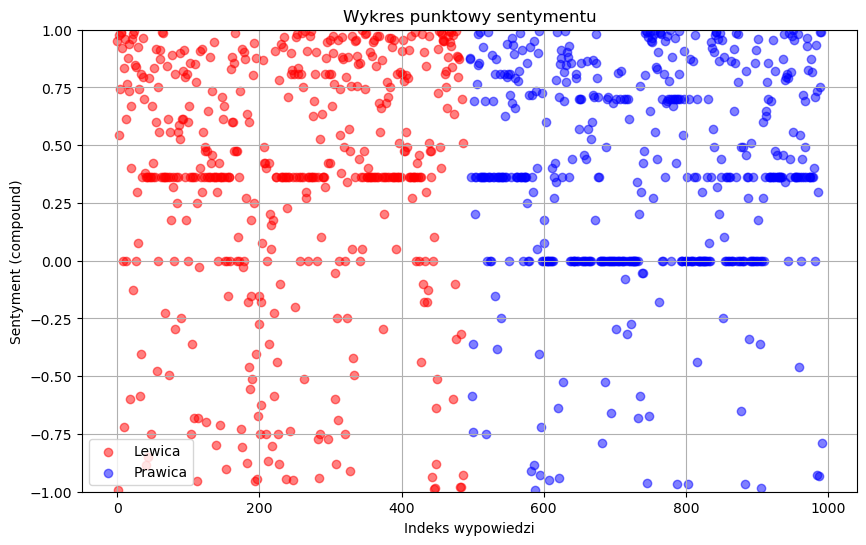

In [43]:
left_values = [item['compound'] for item in left_df['Sentiment']]
right_values = [item['compound'] for item in right_df['Sentiment']]

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(left_values)), left_values, color='red', label='Lewica', alpha=0.5)
plt.scatter(np.arange(len(right_values)) + len(right_values), right_values, color='blue', label='Prawica', alpha=0.5)

plt.xlabel('Indeks wypowiedzi')
plt.ylabel('Sentyment (compound)')
plt.title('Wykres punktowy sentymentu')
plt.legend()
plt.grid(True)
plt.ylim([-1, 1])
plt.show()

Na wykresie punktowym sentymentu można zauważyć kilka interesujących wzorców. W górnej części wykresu widoczna jest większa gęstość kropek niż w dolnej części, co sugeruje, że w tej części danych sentyment jest bardziej zróżnicowany. Można zauważyć, że w okolicach wartości 0.37 występuje skupienie danych, co oznacza, że wiele wypowiedzi ma podobny sentyment w tej okolicy. Warto zwrócić uwagę, że czerwone kropki reprezentują sentyment dla grupy Lewica, a niebieskie kropki reprezentują sentyment dla grupy Prawica. Wykres ten daje nam wizualne spojrzenie na rozkład sentymentu wśród analizowanych wypowiedzi, umożliwiając zidentyfikowanie wzorców i skupień sentymentu w różnych obszarach.

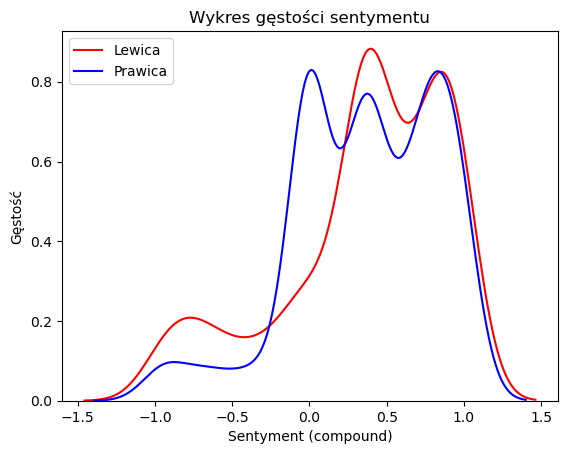

In [46]:
sns.kdeplot(left_df['Sentiment'].apply(lambda x: x['compound']), label='Lewica', color='red')
sns.kdeplot(right_df['Sentiment'].apply(lambda x: x['compound']), label='Prawica', color='blue')
plt.title('Wykres gęstości sentymentu')
plt.xlabel('Sentyment (compound)')
plt.ylabel('Gęstość')
plt.legend()
plt.show()

Na powyższym wykresie można zaobserwować, że większa ilość wypowiedzi lewicowych skupia się w okolicach od -1 do -0,5. Mniejsze skupienie w tych granicach ma zbiór wypowiedzi polityków prawicowych. Na środku widać skupienie dużej ilości wypowiedzi o sentymencie neutralnym, w którym znacząca większość to wypowiedzi prawicy. Po prawej stronie wykresu widać natomiast większe skupienie wypowiedzi pozytywnych, które są w podobnych ilościach dla lewicy i prawicy.

**Najbardziej skrajne wypowiedzi:**

Pozytywne

dla lewicy

In [47]:
left_df_desc = left_df.sort_values(by='Sentiment', ascending=False, key=lambda x: x.apply(lambda y: y['compound']))
print(f"Treść:\n{left_df_desc.iloc[0]['Text']}\nUzyskany wynik:\n{left_df_desc.iloc[0]['Sentiment']}\n")

Treść:
Panie Marszałku! Wysoka Izbo! Tak jak mówiłam wczoraj, będziemy pomagali poprawić ten projekt. W związku z tym w imieniu Klubu Parlamentarnego Koalicja Obywatelska chcę opowiedzieć o poprawkach, które zgłosimy. Pierwsza poprawka zakłada zamianę 2 na 0. To jest zgodne z naszym założeniem programowym. Chcemy oferować Polakom taki kredyt, który pozwoli wielu, wielu rodzinom spełnić marzenia o własnym mieszkaniu. To pozwoli na to, żeby ludzie, którzy wezmą kredyt, nie musieli spłacać go z odsetkami, których wartość często przewyższa wartość pobranego kredytu. Dlatego też nasza pierwsza poprawka będzie dotyczyła właśnie takich zmian. To jest kompleksowa poprawka, która zastępuje oprocentowanie 2 oprocentowaniem 0 ze wszystkimi tego konsekwencjami. 21 Kolejne poprawki dotyczą kwestii, którą poruszaliśmy w czasie debaty zarówno w Sejmie, jak i na posiedzeniu komisji. Mianowicie chcemy, żeby pieniądze, które są zbierane, oszczędzane mogły być również przeznaczane na remonty. Chodzi o re

dla prawicy

In [48]:
right_df_desc = right_df.sort_values(by='Sentiment', ascending=False, key=lambda x: x.apply(lambda y: y['compound']))
print(f"Treść:\n{right_df_desc.iloc[0]['Text']}\nUzyskany wynik:\n{right_df_desc.iloc[0]['Sentiment']}\n")

Treść:
Panie i Panowie Posłowie! Chciałbym pokrótce omówić naszą politykę wobec pozostałych państw sojuszniczych. Stosunek naszych partnerów do rosyjskiej agresji na Ukrainę oraz poziom ich zaangażowania w udzielanie jej pomocy w odpieraniu rosyjskiej agresji są dla nas podstawowym kryterium określającym zakres i intensywność naszej współpracy dwustronnej w najbliższej perspektywie. Należy z satysfakcją stwierdzić, iż od czasu agresji Rosji na Ukrainę mogliśmy liczyć na dobre koalicyjne współdziałanie ze strony Kanady, Norwegii, Danii, Szwecji, Finlandii, Włoch, Hiszpanii, Grecji, Portugalii, Królestwa Niderlandów, Belgii i Luksemburga. Wspólnie podkreślamy znaczenie NATO dla bezpieczeństwa europejskiego i konieczność skutecznej koordynacji inicjatyw unijnych w polityce obronnej z planami i z działaniami Sojuszu. Łączy nas także dążenie do wymierzenia sprawiedliwości sprawcom zbrodni na pokoju, czyli rosyjskiej napaści na Ukrainę oraz zbrodni wojennych popełnianych przez siły rosyjskie

Negatywne

In [ ]:
dla lewicy

In [49]:
left_df_asc = left_df.sort_values(by='Sentiment', ascending=True, key=lambda x: x.apply(lambda y: y['compound']))
print(f"Treść:\n{left_df_asc.iloc[0]['Text']}\nUzyskany wynik:\n{left_df_asc.iloc[0]['Sentiment']}\n")

Treść:
Dziękuję, pani marszałek. Szanowna Pani Marszałek! Zgłaszam wniosek formalny o odroczenie posiedzenia, dlatego że dzisiaj jako politycy jesteśmy odpowiedzialni za to, żeby napisać testament małego Kamilka, testament, dzięki któremu żadne kolejne polskie dziecko nie będzie torturowane tak, jak torturowany był mały Kamilek.   Szanowni Państwo! Niemoc rodzi przemoc. Niemoc państwa jest przyzwoleniem na przemoc dla sprawców tej przemocy. Państwo musi reagować na pierwsze przejawy przemocy  a nie czekać na przemoc ostateczną, która kończy się śmiercią, niejednokrotnie śmiercią dziecka, śmiercią kobiety. W Sejmie jest projekt ustawy  o systemowej analizie przypadków śmierci dzieci. To jest ustawa  
Uzyskany wynik:
{'neg': 0.441, 'neu': 0.449, 'pos': 0.11, 'compound': -0.9908}



dla prawicy

In [50]:
right_df_asc = right_df.sort_values(by='Sentiment', ascending=True, key=lambda x: x.apply(lambda y: y['compound']))
print(f"Treść:\n{right_df_asc.iloc[0]['Text']}\nUzyskany wynik:\n{right_df_asc.iloc[0]['Sentiment']}\n")

Treść:
Naprawdę tak rzadko zdarza się, żeby ten Sejm zamiast odbierać nam wolność, w czymkolwiek nam ją zwracał, w czymkolwiek ją poszerzał. Tutaj mamy oczywiście skutek jakiegoś wieloletniego bankructwa tych wszystkich państwowych programów budowlanych i wobec tego nawet PiS już rozumie, że trzeba czasami poluzować śrubę. Co wtedy powinna zrobić opozycja? Opozycja powinna wtedy wyjść i zachęcać rząd: Czemu tak mało, czemu więcej nam wolności nie zwrócicie, przecież my chcemy jeszcze więcej budować, jeszcze więcej decydować sami o sobie na swoich własnych działkach.  To jest normalne, to jest stan domyślny, że ja na swojej działce mogę budować bez pytania kogokolwiek o zdanie to, co mi się podoba. Powinny być co najwyższej od tego wyjątki, kiedy muszę kogoś zapytać, a nie odwrotnie. Ale co robi opozycja w rzeczywistym świecie? Co robi nasza lewicowa opozycja? Ano biadoli, że co to będzie. Pani Chmiel płacze po prostu, bez dziennika budowy, bez kierownika, bez zezwolenia, bez pieczątki,